## HW03
Deep Learning, GIST RT5101-01, 2021, Spring, (Tue/Thurs 2:30~3:45)
***


How to submit your homework
Submit your jupyter notebook file with the filename of HW03_studentnumber.ipynb on GEL
Ex) HW03_20201106.ipynb

Submission deadline
2021.05.19, Wednesday 23:59 (PM)

Plagiarism
We encourage you to discuss this homework with your friends or TA, but you should write your own code.

### About the VGGNet

- VGGNet is invented by VGG (Visual Geometry Group) from the University of Oxford ([paper](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=2ahUKEwilz7Ptu4jiAhWIdXAKHYr9BK0QFjAAegQIAhAC&url=https%3A%2F%2Farxiv.org%2Fpdf%2F1409.1556&usg=AOvVaw3u_l2DJveBaeO_vs_qyLMT))
- VGGNet is the 1st runner-up, not the winner of the ILSVRC (ImageNet Large Scale Visual Recognition Competition) 2014 in the classification task
- Nevertheless, VGGNet beats the GoogLeNet and won the localization task in ILSVRC 2014.
- There are many other models built on top of VGGNet or based on the 3×3 conv idea of VGGNet for other purposes or other domains.
- In the paper, there is 5 version of VGGNet. Here, you have to implement the VGG-11.

![대체 텍스트](https://cdn-images-1.medium.com/max/1200/1*_1DEx3bHlnBApCWWQ0HgcQ.png)

Your homework consists of the following steps:

1. Build a VGGNet-11
2. visualize the results after training and testing it.
3. apply augmentation by transform function and repeat step 2.
4. compare results of step 2 and 3.

The codes for loading the CIFAR10 dataset will be given.   

### Plagiarism
We encourage you to discuss this homework with your friends or TA, but you should write your own code.




## Guide: Load CIFAR10 Dataset
---
Before training the VGGNet-16, Let's load CIFAR10 dataset   
`Note: All the codes in this guide is the same as the lecture material.`



Let's import required python package

Here, ``torchvision`` module provides useful benchmark datasets and image transfromation functions


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

Define device configuration (CPU Computation or GPU Computation)

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [14]:
# Hyper parameters
num_epochs = 100 # number of epochs for train
batch_size = 128 # do not change this value
learning_rate = 0.0001 # do not change this value

Download CIFAR10 dataset

You can check the number of dataset by printing ```len(dataset)```




In [15]:
# CIFAR10 dataset

composed_transforms = transforms.Compose([transforms.Resize((64,64)),
                                         transforms.ToTensor(),]) # 32,32 to 64,64

train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                           train=True, 
                                           transform=composed_transforms,                                          
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                          train=False, 
                                          transform=composed_transforms)

print('Number of train images: {}'.format(len(train_dataset)))
print('Number of test images: {}'.format(len(test_dataset)))


Files already downloaded and verified
Number of train images: 50000
Number of test images: 10000


```torch.utils.data.DataLoader``` shuffles the training data and devides the entire data with ```batch_size```



In [16]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

Size of single image tensor: torch.Size([3, 64, 64])
Size of single image array: (64, 64, 3)



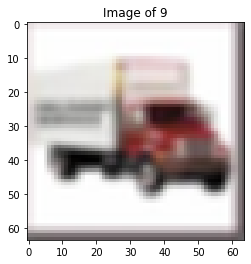

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Get single image data
image_tensor, image_label = train_dataset.__getitem__(random.randint(0, len(train_dataset)))
print('Size of single image tensor: {}'.format(image_tensor.size()))

# Torch tensor to numpy array
image_array = image_tensor.squeeze().numpy()
image_array = np.transpose(image_array, (1, 2, 0))

print('Size of single image array: {}\n'.format(image_array.shape))

# Plot image
plt.title('Image of {}'.format(image_label))
plt.imshow(image_array)


## Problem1. Implementation of VGGNet-11 (25%)


- Implement the convolutional layers fully connected layers in `self.features` and `self.classifiers`, respectively.
- VGGNet-11 consists of 6 convolutional layers and three fully connected layers.

- Convolutional layers

| layer       | feature maps | kernel size | stride | padding | activation |
|:-------------:|:--------------:|-------------|--------|---------|------------|
| input image | 3            | -           | -      | -       | -          |
|    conv1    |      64      |     3x3     |   1x1  |   1x1   |    relu    |
|   maxpool1  |      64      |     2x2     |   2x2  |    -    |      -     |
|    conv2    |      128     |     3x3     |   1x1  |   1x1   |    relu    |
|   maxpool2  |      128     |     2x2     |   2x2  |    -    |      -     |
|    conv3    |      256     |     3x3     |   1x1  |   1x1   |    relu    |
|    conv4    |      256     |     3x3     |   1x1  |   1x1   |    relu    |
|   maxpool3  |      256     |     2x2     |   2x2  |    -    |      -     |
|    conv5    |      512     |     3x3     |   1x1  |   1x1   |    relu    |
|    conv6    |      512     |     3x3     |   1x1  |   1x1   |    relu    |
|   maxpool4  |      512     |     2x2     |   2x2  |    -    |      -     |
|    conv7    |      512     |     3x3     |   1x1  |   1x1   |    relu    |
|    conv8    |      512     |     3x3     |   1x1  |   1x1   |    relu    |
|   maxpool5  |      512     |     2x2     |   2x2  |    -    |      -     |

- Fully connected layers.

|  layer  | size | activation |
|:-------:|:----:|:----------:|
| linear1 | 4096 |    relu    |
| dropout |   -  |      -     |
| linear2 | 4096 |    relu    |
| dropout |   -  |      -     |
| linear3 | 4096 |  num_class |


[Reference](https://https://medium.com/coinmonks/paper-review-of-vggnet-1st-runner-up-of-ilsvlc-2014-image-classification-d02355543a11)

※ You can use AvgPooling before classifier because of large memory.

In [18]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        
        self.features = nn.Sequential(
            # convolutional layers
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),            
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            # FClayers
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

## Problem2. Train and Test the VGGNet-11 (25%)

1.  Define the criterion and optimizer (use the CrossEntropyLoss and Adam optimizer)
- Using the `train_loader`, train the VGGNet on CIFAR10 dataset for 10 epoch 
- While training, monitor the training loss and accuracy and draw the graph (loss vs. epoch | accuracy vs. epoch) with matplotlib
- After training the model, check the validation loss and accuracy by running your trained model on the test dataset. (Use the `test_loader`)
- While test the model, draw the graph (loss vs epoch | accuracy vs epoch) with matplotlib

In [19]:
# plot function
def show_plot(loss_arr, acc_arr, split):
    epochs = range(1, len(loss_arr) + 1)
    label = split

    plt.clf()
    #plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_arr, linestyle='--', label=label)    
    plt.title('{} loss'.format(label))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc_arr, linestyle='--', label=label)    
    plt.title('{} accuracy'.format(label))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [20]:
# train and test
model = VGGNet().to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)
log_interval = 100
best_acc = 0

train_loss_arr = []
train_acc_arr = []
val_loss_arr = []
val_acc_arr = []

In [24]:
print(model)

VGGNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

In [21]:
def train(epoch):
    log_interval = 100    
    print('\nEpoch: %d' % epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Printing the result at the specific interval
        if batch_idx % log_interval == 0: # log_interval = 100
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f} | Train Acc: {:.3f}%".format(
                epoch, batch_idx, len(train_loader), 100. * batch_idx / len(train_loader),
                loss.item(), 100.*correct/total))  
    
    train_loss_arr.append(train_loss)
    train_acc_arr.append(100.*correct/total)

In [22]:
def test(epoch):
    global best_acc
    log_interval = 10
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Save checkpoint.
    acc = 100.*correct/total    

    if acc > best_acc:
        print('Saving..')
        state = {
            'net': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc    
    
    print("Test Loss: {:.6f} | Test Acc: {:.3f}%".format(test_loss/epoch, best_acc))  


Epoch: 1
Train Epoch: 1 [0/391 (0%)]	Train Loss: 2.303435 | Train Acc: 10.938%
Train Epoch: 1 [100/391 (26%)]	Train Loss: 2.303574 | Train Acc: 9.514%
Train Epoch: 1 [200/391 (51%)]	Train Loss: 2.302185 | Train Acc: 9.841%
Train Epoch: 1 [300/391 (77%)]	Train Loss: 2.302608 | Train Acc: 9.863%


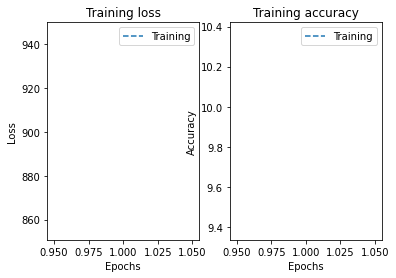

Saving..
Test Loss: 181.905500 | Test Acc: 10.000%

Epoch: 2
Train Epoch: 2 [0/391 (0%)]	Train Loss: 2.303662 | Train Acc: 7.812%
Train Epoch: 2 [100/391 (26%)]	Train Loss: 2.303273 | Train Acc: 10.056%
Train Epoch: 2 [200/391 (51%)]	Train Loss: 2.302510 | Train Acc: 9.946%
Train Epoch: 2 [300/391 (77%)]	Train Loss: 2.302653 | Train Acc: 9.993%


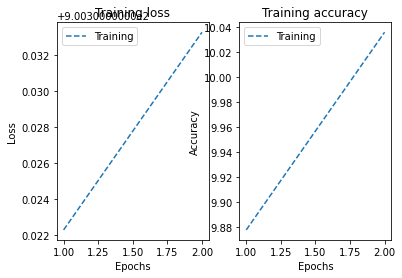

Test Loss: 90.952654 | Test Acc: 10.000%

Epoch: 3
Train Epoch: 3 [0/391 (0%)]	Train Loss: 2.301973 | Train Acc: 10.156%
Train Epoch: 3 [100/391 (26%)]	Train Loss: 2.303572 | Train Acc: 9.785%
Train Epoch: 3 [200/391 (51%)]	Train Loss: 2.301862 | Train Acc: 9.900%
Train Epoch: 3 [300/391 (77%)]	Train Loss: 2.301584 | Train Acc: 9.993%


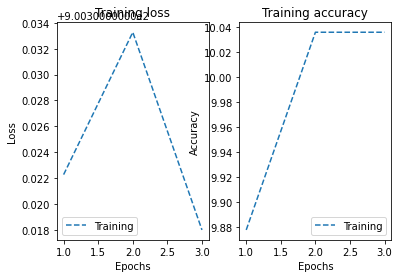

Test Loss: 60.635046 | Test Acc: 10.000%

Epoch: 4
Train Epoch: 4 [0/391 (0%)]	Train Loss: 2.302480 | Train Acc: 8.594%
Train Epoch: 4 [100/391 (26%)]	Train Loss: 2.301793 | Train Acc: 9.684%
Train Epoch: 4 [200/391 (51%)]	Train Loss: 2.302787 | Train Acc: 9.826%
Train Epoch: 4 [300/391 (77%)]	Train Loss: 2.302488 | Train Acc: 10.019%


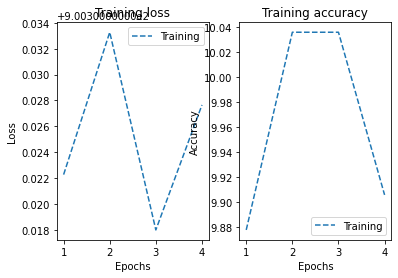

Test Loss: 45.476255 | Test Acc: 10.000%

Epoch: 5
Train Epoch: 5 [0/391 (0%)]	Train Loss: 2.303066 | Train Acc: 10.156%
Train Epoch: 5 [100/391 (26%)]	Train Loss: 2.302006 | Train Acc: 10.094%
Train Epoch: 5 [200/391 (51%)]	Train Loss: 2.302764 | Train Acc: 10.308%
Train Epoch: 5 [300/391 (77%)]	Train Loss: 2.301052 | Train Acc: 10.307%


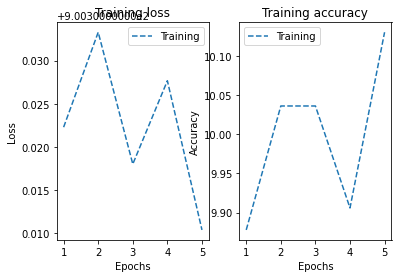

Test Loss: 36.380979 | Test Acc: 10.000%

Epoch: 6
Train Epoch: 6 [0/391 (0%)]	Train Loss: 2.303396 | Train Acc: 12.500%
Train Epoch: 6 [100/391 (26%)]	Train Loss: 2.302867 | Train Acc: 10.002%
Train Epoch: 6 [200/391 (51%)]	Train Loss: 2.302168 | Train Acc: 9.896%
Train Epoch: 6 [300/391 (77%)]	Train Loss: 2.302854 | Train Acc: 9.767%


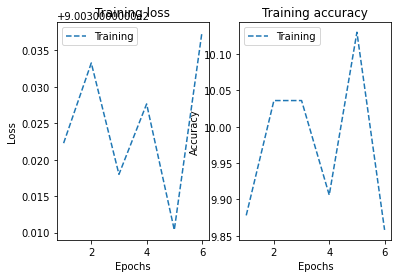

KeyboardInterrupt: 

In [23]:
for epoch in range(1, num_epochs + 1):
    train(epoch)
    show_plot(train_loss_arr, train_acc_arr, 'Training')
    test(epoch)

In [ ]:
# draw the graph


## Problem3. Apply Data Augmentation on your VGGNet-11 (25%)

1.  Use transform.Compose function, apply data augmentation to your VGG model.

[Reference](https://pytorch.org/vision/stable/_modules/torchvision/transforms/transforms.html#Compose)

### Example)
- Use RandomHorizontalFlip, flip the image with a probability of 0.5.
- Use RandomRotation, tilt randomly to 10 degrees or less.
- Use ColorJitter, Randomly adjust brightness, contrast, and saturation. (0.2)
- Or something want to apply.

In [ ]:
# CIFAR10 dataset

composed_transforms = transforms.Compose([transforms.Resize((64,64)),
                                         transforms.ToTensor(),
                                         # apply additional agmentation
                                          
                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                         ]) # 32,32 to 64,64

train_dataset = torchvision.datasets.CIFAR10(root='./data',
                                           train=True, 
                                           transform=composed_transforms,                                          
                                           download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data',
                                          train=False, 
                                          transform=composed_transforms)

print('Number of train images: {}'.format(len(train_dataset)))
print('Number of test images: {}'.format(len(test_dataset)))

In [ ]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import random

# Get single image data
image_tensor, image_label = train_dataset.__getitem__(random.randint(0, len(train_dataset)))
print('Size of single image tensor: {}'.format(image_tensor.size()))

# Torch tensor to numpy array
image_array = image_tensor.squeeze().numpy()
image_array = np.transpose(image_array, (1, 2, 0))

print('Size of single image array: {}\n'.format(image_array.shape))

# Plot image
plt.title('Image of {}'.format(image_label))
plt.imshow(image_array)

In [ ]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()
        
        self.features = nn.Sequential(
            # convolutional layers
        )
        
        self.classifier = nn.Sequential(
            # FClayers
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

## Problem4. Apply Data Augmentation on your VGGNet-11 (25%)

1.  In same condition with Problem 1 and 2, train and test your model.
2.  Compare the results of Problem 2 and write a simple discussion.